# Download the dataset

In [1]:
import os
import requests
import zipfile
import io

dataset_url = "https://www.kaggle.com/api/v1/datasets/download/firecastrl/us-wildfire-dataset"
destination = "Wildfire_Dataset.csv"
if os.path.isfile(destination) == False:
    print(f"Downloading dataset from {dataset_url}...")
    zip = requests.get(dataset_url, allow_redirects=True)
    zipfile.ZipFile(io.BytesIO(zip.content)).extractall()
else:
    print(f"{destination} already exists. Skipping download.")

print("Dataset is ready.")

Wildfire_Dataset.csv already exists. Skipping download.
Dataset is ready.


# Dataset Shape

In [2]:
import pandas as pd

df = pd.read_csv("Wildfire_Dataset.csv", parse_dates=["datetime"])

print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\n")
df.head()

Shape: (9509925, 19)

Columns: ['latitude', 'longitude', 'datetime', 'Wildfire', 'pr', 'rmax', 'rmin', 'sph', 'srad', 'tmmn', 'tmmx', 'vs', 'bi', 'fm100', 'fm1000', 'erc', 'etr', 'pet', 'vpd']




,latitude,longitude,datetime,Wildfire,pr,rmax,rmin,sph,srad,tmmn,tmmx,vs,bi,fm100,fm1000,erc,etr,pet,vpd
0,48.128431,-97.276685,2018-08-15,No,0.0,78.6,14.9,0.00582,272.6,282.0,301.6,3.0,40.0,10.2,12.2,54.0,7.5,5.5,1.59
1,48.128431,-97.276685,2018-08-16,No,0.0,80.4,13.9,0.00676,264.0,283.9,304.9,3.0,40.0,9.7,12.0,56.0,8.2,5.9,1.93
2,48.128431,-97.276685,2018-08-17,No,0.0,70.9,20.4,0.00672,265.6,285.8,300.7,3.1,40.0,9.2,11.9,56.0,7.2,5.3,1.51
3,48.128431,-97.276685,2018-08-18,No,5.0,65.2,19.4,0.00756,261.4,289.0,303.3,5.1,0.0,9.9,12.0,40.0,10.0,6.9,1.85
4,48.128431,-97.276685,2018-08-19,No,0.0,100.0,42.2,0.00895,166.8,283.8,296.5,4.7,41.0,11.8,12.1,47.0,4.6,3.4,0.66


# Class Distribution

Wildfire
No     9007860
Yes     502065
Name: count, dtype: int64




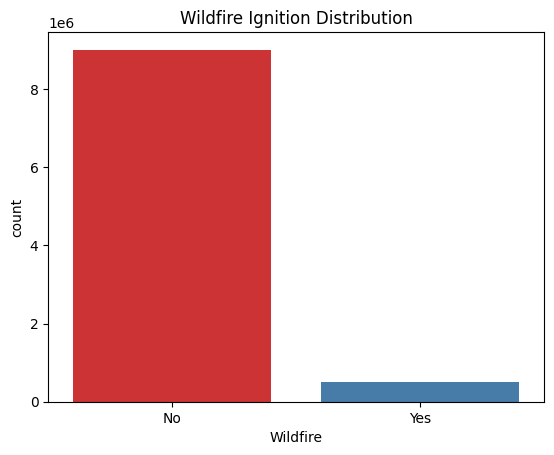

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

print(df["Wildfire"].value_counts())
print("\n")

sns.countplot(x="Wildfire", data=df, hue="Wildfire", palette="Set1", legend=False)
plt.title("Wildfire Ignition Distribution")
plt.show()

# Wildfire by Lat/Long

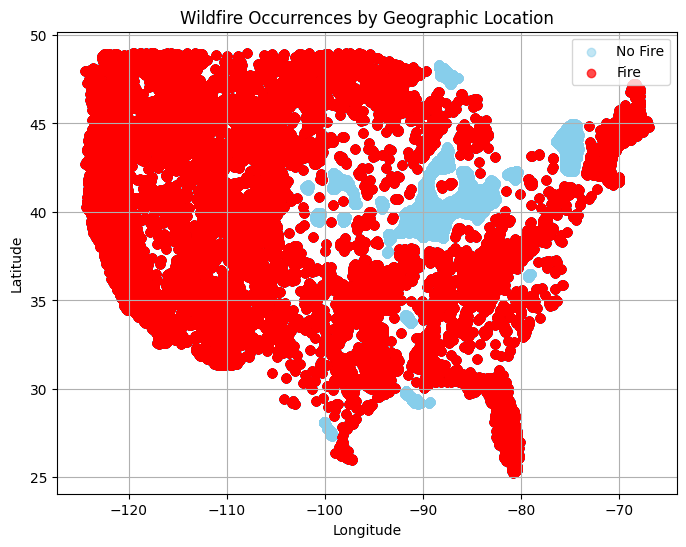

In [4]:
plt.figure(figsize=(8, 6))

# No fire
plt.scatter(
    df[df["Wildfire"] == "No"]["longitude"],
    df[df["Wildfire"] == "No"]["latitude"],
    color="skyblue",
    label="No Fire",
    alpha=0.5,
)

# fire
plt.scatter(
    df[df["Wildfire"] == "Yes"]["longitude"],
    df[df["Wildfire"] == "Yes"]["latitude"],
    color="red",
    label="Fire",
    alpha=0.7,
)

plt.title("Wildfire Occurrences by Geographic Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

# Add Month, Year, Day of Year to Columns

In [5]:
# Convert datetime column
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce")

# Create columns for exploration
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["dayofyear"] = df["datetime"].dt.dayofyear

# Split Data Into 75 Day Blocks

In [6]:
import numpy as np

SEQ_LEN = 75
FEATURES = [
    "pr",
    "rmax",
    "rmin",
    "sph",
    "srad",
    "tmmn",
    "tmmx",
    "vs",
    "bi",
    "fm100",
    "fm1000",
    "erc",
    "etr",
    "pet",
    "vpd",
]

df = df.sort_values(["latitude", "longitude", "datetime"]).reset_index(drop=True)
df["seq_id"] = np.arange(len(df)) // SEQ_LEN

n_features = len(FEATURES)
n_seq = len(df) // SEQ_LEN

# Trim the DataFrame to include only complete sequences (crucial for clean reshaping)
df_trimmed = df.iloc[: n_seq * SEQ_LEN].copy()

X_flat = df_trimmed[FEATURES].values
seqs = X_flat.reshape((n_seq, SEQ_LEN, n_features))

wildfire_indicator = (df_trimmed["Wildfire"] == "Yes").astype(int)

labels = wildfire_indicator.groupby(df_trimmed["seq_id"]).max().values

print(f"Final seqs shape: {seqs.shape}")
print(f"Final labels shape: {labels.shape}")

# remove the fill valued data points(occurs when GRIDMET doesn't have data for that particular coord datetime)
fill_value = 32767.0
valid_mask = ~np.any(seqs == fill_value, axis=(1, 2))
seqs = seqs[valid_mask]
labels = labels[valid_mask]
print(f"Valid seqs shape: {seqs.shape}")
print(f"Valid labels shape: {labels.shape}")


Final seqs shape: (126799, 75, 15)
Final labels shape: (126799,)
Valid seqs shape: (126456, 75, 15)
Valid labels shape: (126456,)


# Train/Test Split

In [7]:
# Train/Test Split
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(
    seqs, labels, test_size=0.2, random_state=42, stratify=labels
)

#Also split by year (before 2019 train, 2019 and after test)
#train_mask = df_trimmed['year'].values[:len(labels)] < 2019
#train_x = seqs[train_mask]
#train_y = labels[train_mask]
#test_x = seqs[~train_mask]
#test_y = labels[~train_mask]


# x is dim 3 – need to reshape to dim 2 for scaler
train_x_2d = train_x.reshape((train_x.shape[0], -1))
test_x_2d = test_x.reshape((test_x.shape[0], -1))
test_y_2d = test_x.reshape((test_x.shape[0], -1))

print(f"Train X shape: {train_x_2d.shape}, Train y shape: {train_y.shape}")
print(f"Test X shape: {test_x_2d.shape}, Test y shape: {test_y.shape}")

Train X shape: (101164, 1125), Train y shape: (101164,)
Test X shape: (25292, 1125), Test y shape: (25292,)


# Standardize The Data

In [8]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_x_2d = scaler.fit_transform(train_x_2d)
test_x_2d = scaler.transform(test_x_2d)



# Logistic Regression Training

In [9]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(train_x_2d, train_y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


# Evaluation

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

y_pred = model.predict(test_x_2d)
acc = accuracy_score(test_y, y_pred)

print(f"Accuracy: {acc:.3f}")
print("Confusion Matrix:\n", confusion_matrix(test_y, y_pred))
print("\nClassification Report:\n", classification_report(test_y, y_pred))

Accuracy: 0.739
Confusion Matrix:
 [[18164   471]
 [ 6123   534]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.97      0.85     18635
           1       0.53      0.08      0.14      6657

    accuracy                           0.74     25292
   macro avg       0.64      0.53      0.49     25292
weighted avg       0.69      0.74      0.66     25292



# Random Forest

In [11]:
# Random Forest Classifier for comparison
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_x_2d, train_y)
rf_y_pred = rf_model.predict(test_x_2d)
rf_acc = accuracy_score(test_y, rf_y_pred)
print(f"Random Forest Accuracy: {rf_acc:.3f}")
print("Random Forest Confusion Matrix:\n", confusion_matrix(test_y, rf_y_pred))
print("\nRandom Forest Classification Report:\n", classification_report(test_y, rf_y_pred))


Random Forest Accuracy: 0.759
Random Forest Confusion Matrix:
 [[18188   447]
 [ 5638  1019]]

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.98      0.86     18635
           1       0.70      0.15      0.25      6657

    accuracy                           0.76     25292
   macro avg       0.73      0.56      0.55     25292
weighted avg       0.75      0.76      0.70     25292

